# Generating Dwight Shrute lines using NLP & Deep Learning
(A first step in the development of a Twitter chatbot that responds to tweets like Dwight Shrute from NBC's hit series "The Office")

- By: Colby Shelton

# Overview

- Explore and clean our data.
- Create a Multi-Class Text Classifier using sklearn to predict character quote. The goal here is to measure if Dwight's lines are unique enough to predict in a set of 4 other characters.
- Create Neural Language Text Generation Model trained on Dwight's lines.
- Run the generated lines though the Text Classifier and observe if the model predicts the line to be Dwight.
- Conclusion
- Future steps

In [48]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Data Cleaning / Exploration

In [49]:
# Read in dataframe
df = pd.read_csv('/Users/colby/Desktop/Thinkful/the-office-lines - scripts.csv', encoding="utf-8", index_col=False)

df.shape

(59909, 7)

In [50]:
df.head()

,id,season,episode,scene,line_text,speaker,deleted
0,1,1,1,1,All right Jim. Your quarterlies look very good. How are things at the library?,Michael,False
1,2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
2,3,1,1,1,"So you've come to the master for guidance? Is this what you're saying, grasshopper?",Michael,False
3,4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
4,5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False


In [51]:
# Convert line to lowercase
df['line_text'] = df['line_text'].str.lower()

# Drop punctuation from line_text
df['line_text'] = df['line_text'].str.replace("[\(\[].*?[\)\]]", "",regex=True)

In [52]:
# Delete all columns minus line_text and speaker
df.drop(['id', 'season', 'episode', 'scene', 'deleted'], axis = 1, inplace = True)

# Create a text file of Dwight's lines only to use for text generation model

In [53]:
# Create a df that contain Dwight's line only
# This will be used to sample for testing on the Multi_class Test Classifier,
# then to train the Neural Language Text Generation Model after conversion to a .txt file.
dwight_only_df = df[df['speaker'] == 'Dwight']

In [54]:
# Drop 'speaker column'
dwight_only_df.drop(['speaker'], axis = 1, inplace = True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [55]:
# Create new variable as the number of words in line_text
dwight_only_df['line_total_words'] = [len(x.split()) for x in dwight_only_df['line_text'].tolist()]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [56]:
# Delete line with less than 4 words
dwight_only_df = dwight_only_df[ (dwight_only_df['line_total_words'] >= 4) ]

In [57]:
# Drop 'speaker column'
dwight_only_df.drop(['line_total_words'], axis = 1, inplace = True)

# Convert to .txt file
#np.savetxt(r'dwight_only.txt', dwight_only_df.values, fmt='%s', delimiter="\t")

# Create new data frame of top 5 characters by line including Dwight to test if Dwight's lines are predictably different

In [58]:
# Check line count per character.
print(df['speaker'].value_counts())

Michael                              12137
Dwight                                7529
Jim                                   6814
Pam                                   5375
Andy                                  3968
Kevin                                 1708
Angela                                1695
Oscar                                 1490
Erin                                  1469
Ryan                                  1379
Darryl                                1243
Phyllis                               1071
Kelly                                  956
Jan                                    949
Toby                                   936
Stanley                                761
Meredith                               645
Holly                                  608
Nellie                                 529
Creed                                  456
Gabe                                   436
Robert                                 430
David                                  382
Karen      

In [59]:
# Limit to top five characters based on line count including Dwight

# Get the count of each value
value_counts = df['speaker'].value_counts()

# Select the values where the count is less than 1379 (Limit to top five charaters based on line count)
to_remove = value_counts[value_counts < 3968].index

# Keep rows where the column is not in to_remove
df = df[~df.speaker.isin(to_remove)]

In [60]:
# Create new variable as the number of words in line_text
df['line_total_words'] = [len(x.split()) for x in df['line_text'].tolist()]

In [61]:
# Delete line with less than 4 words
df = df[ (df['line_total_words'] >= 4) ]

In [62]:
# Drop 'line_total_words' column
df.drop(['line_total_words'], axis = 1, inplace = True)

In [63]:
df.head()

,line_text,speaker
0,all right jim. your quarterlies look very good. how are things at the library?,Michael
1,"oh, i told you. i couldn't close it. so...",Jim
2,"so you've come to the master for guidance? is this what you're saying, grasshopper?",Michael
3,"actually, you called me in here, but yeah.",Jim
4,"all right. well, let me show you how it's done.",Michael


# Multi-Class Text Classifier

This model will be used for two purposes:

- Evaluate if Dwight's lines unique enough to predict.
- After creattion of text generator, the lines will be tested on this model to see if they are predicted as being Dwight's lines.

In [64]:
# Select five indices of your choice you wish to sample from the dataset to test
# on the Multi_class Test Classifier
indices = [95,32297,59618,57863,43454]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(df.loc[indices], columns = df.keys()).reset_index(drop = True)
print("Chosen samples of dataset:")
display(samples)

Chosen samples of dataset:


,line_text,speaker
0,"downsizing? i have no problem with that. i have been recommending downsizing since i first got here. i even brought it up in my interview. i say, bring it on.",Dwight
1,"i knew it! more trunk space. or should i say, corpse space.",Dwight
2,"a ceremonial bridal kidnapping. he will take the bride and hide her at a local pub and when i find the place, i have to buy everyone drinks. ah, all right! oh mose.",Dwight
3,no woman would ever want a man who doesn't know what an auger is.,Dwight
4,ooh does edgar allan poe know about that one? so sinister! that wouldn't annoy a person at all! where do you come up with this stuff?,Dwight


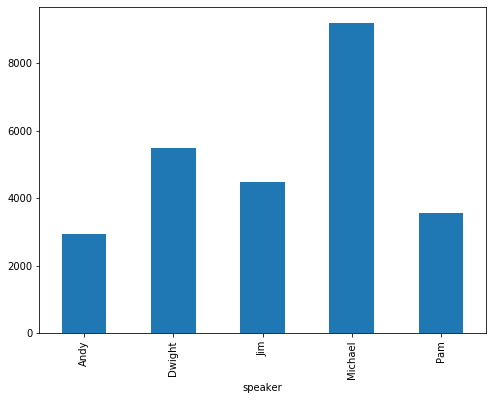

In [65]:
# Plot distribution of speakers
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('speaker').line_text.count().plot.bar(ylim=0)
plt.show()

The 'Michael' class is obviously the vast majority. We'll balance that out in a few steps to level the playing field.

## Text Representation using TF-IDF

The classifiers and learning algorithms can not directly process the text documents in their original form, as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length. Therefore, during the preprocessing step, the texts are converted to a more manageable representation.

One common approach for extracting features from text is to use the bag of words model: a model where for each document, a line_text in our case, the presence (and often the frequency) of words is taken into consideration, but the order in which they occur is ignored.

Specifically, for each term in our dataset, we will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf.

In [66]:
# Create new variable speaker_id for numerical representation of speaker
df['speaker_id'] = df['speaker'].factorize()[0]

from io import StringIO

# Create a few dictionaries for future use
speaker_id_df = df[['speaker', 'speaker_id']].drop_duplicates().sort_values('speaker_id')
speaker_to_id = dict(speaker_id_df.values)
id_to_speaker = dict(speaker_id_df[['speaker_id', 'speaker']].values)

In [69]:
# Let't random sample and drop %40 of Michael's lines
df = df.drop(df.query('speaker_id == 0').sample(frac=.4).index)

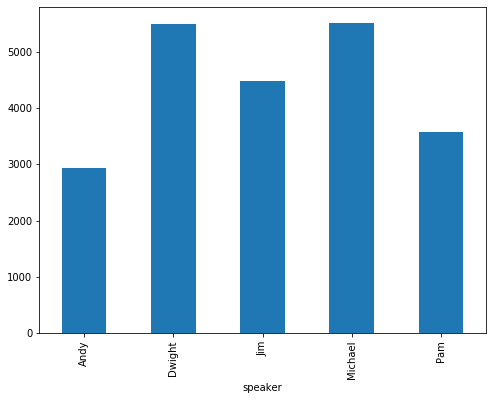

In [70]:
# Plot distribution of speakers after random sample and removal of %40 of Michael's lines
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('speaker').line_text.count().plot.bar(ylim=0)
plt.show()

In [71]:
# sublinear_df is set to True to use a logarithmic form for frequency.
# min_df is the minimum numbers of documents a word must be present in to be kept.
# norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
# ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
# stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True,
                        min_df=5,
                        norm='l2',
                        encoding='latin-1',
                        ngram_range=(1, 2),
                        stop_words='english'
                       )

features = tfidf.fit_transform(df.line_text).toarray()
labels = df.speaker_id
features.shape

(21993, 4931)

In [72]:
# Find the terms that are the most correlated with each of the speakers:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for speaker, speaker_id in sorted(speaker_to_id.items()):
    features_chi2 = chi2(features, labels == speaker_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(speaker))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Andy':
  . Most correlated unigrams:
       . erin
       . tuna
  . Most correlated bigrams:
       . big tuna
       . nard dog
# 'Dwight':
  . Most correlated unigrams:
       . um
       . schrute
  . Most correlated bigrams:
       . ve got
       . dwight schrute
# 'Jim':
  . Most correlated unigrams:
       . nope
       . definitely
  . Most correlated bigrams:
       . just gonna
       . really sure
# 'Michael':
  . Most correlated unigrams:
       . michael
       . everybody
  . Most correlated bigrams:
       . okay right
       . know know
# 'Pam':
  . Most correlated unigrams:
       . um
       . michael
  . Most correlated bigrams:
       . hey michael
       . mifflin pam


# Multi-Class Classifier: Features and Design

To train supervised classifiers, we first transformed the “line_text” into a vector of numbers. We explored vector representations such as TF-IDF weighted vectors.

After having this vector representations of the text we can train supervised classifiers to train unseen “line_text” samples and predict the “speaker".

After all the above data transformation, now that we have all the features and labels, it is time to train the classifiers. There are a number of algorithms we can use for this type of problem.

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['line_text'], df['speaker'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [74]:
# Let's do a quick prediction on a line I made up. Something that sounds like Dwight.
print(clf.predict(count_vect.transform(["I am a beet farmer and I want to be manager."])))

['Dwight']


## Model Selection

We are now ready to experiment with multiple machine learning models.

We will test the following four models:
- Logistic Regression
- (Multinomial) Naive Bayes
- Linear Support Vector Machine
- Random Forest

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=123),
]

CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.


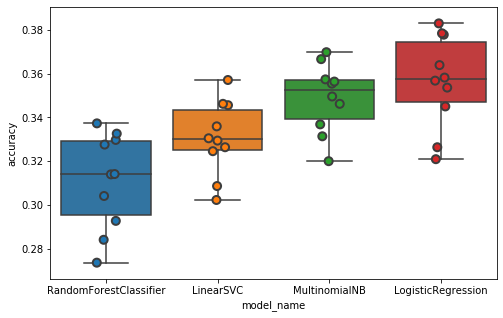

In [86]:
# Visualize model accuracies
import seaborn as sns
plt.figure(figsize=(8,5))

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [87]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.330640
LogisticRegression        0.356417
MultinomialNB             0.348967
RandomForestClassifier    0.310947
Name: accuracy, dtype: float64

#### MultinomialNB and Logistic Regression perform better than the other two classifiers, with LogisticRegression having a slight advantage with a median accuracy of around 35.6%.

We'll continue with Logistic Regression

In [94]:
from sklearn.model_selection import train_test_split

model2 = LogisticRegression(random_state=123)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


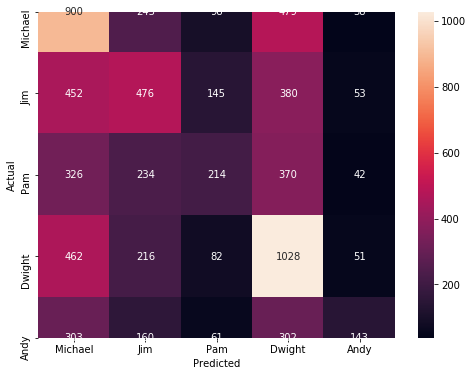

In [95]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=speaker_id_df.speaker.values, yticklabels=speaker_id_df.speaker.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [96]:
model2.fit(features, labels)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

# Classification report for each class

In [97]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['speaker'].unique()))

              precision    recall  f1-score   support

         Jim       0.37      0.51      0.43      1758
     Michael       0.36      0.32      0.34      1506
         Pam       0.36      0.18      0.24      1186
      Dwight       0.40      0.56      0.47      1839
        Andy       0.44      0.15      0.22       969

    accuracy                           0.38      7258
   macro avg       0.38      0.34      0.34      7258
weighted avg       0.38      0.38      0.36      7258



### Let's print out the sample so we can run them throught the model and see how they are classified

In [82]:
# I want to copy the full line
pd.options.display.max_colwidth = 250

samples

,line_text,speaker
0,"downsizing? i have no problem with that. i have been recommending downsizing since i first got here. i even brought it up in my interview. i say, bring it on.",Dwight
1,"i knew it! more trunk space. or should i say, corpse space.",Dwight
2,"a ceremonial bridal kidnapping. he will take the bride and hide her at a local pub and when i find the place, i have to buy everyone drinks. ah, all right! oh mose.",Dwight
3,no woman would ever want a man who doesn't know what an auger is.,Dwight
4,ooh does edgar allan poe know about that one? so sinister! that wouldn't annoy a person at all! where do you come up with this stuff?,Dwight


# Test Dwight's sample lines

In [98]:
texts = ["downsizing? i have no problem with that. i have been recommending downsizing since i first got here. i even brought it up in my interview. i say, bring it on.",
        'i knew it! more trunk space. or should i say, corpse space.',
        'a ceremonial bridal kidnapping. he will take the bride and hide her at a local pub and when i find the place, i have to buy everyone drinks. ah, all right! oh mose',
        'no woman would ever want a man who doesnt know what an auger is.',
        'ooh does edgar allan poe know about that one? so sinister! that wouldnt annoy a person at all! where do you come up with this stuff?']
text_features = tfidf.transform(texts)
predictions = model2.predict(text_features)
for text, predicted in zip(texts, predictions):
    print('"{}"'.format(text))
    print("  - Predicted as: '{}'".format(id_to_speaker[predicted]))
    print("")

"downsizing? i have no problem with that. i have been recommending downsizing since i first got here. i even brought it up in my interview. i say, bring it on."
  - Predicted as: 'Dwight'

"i knew it! more trunk space. or should i say, corpse space."
  - Predicted as: 'Dwight'

"a ceremonial bridal kidnapping. he will take the bride and hide her at a local pub and when i find the place, i have to buy everyone drinks. ah, all right! oh mose"
  - Predicted as: 'Dwight'

"no woman would ever want a man who doesnt know what an auger is."
  - Predicted as: 'Michael'

"ooh does edgar allan poe know about that one? so sinister! that wouldnt annoy a person at all! where do you come up with this stuff?"
  - Predicted as: 'Michael'



# Neural Language Text Generation Model

We will develop a model of the text that we can then use to generate new sequences of Dwight lines using the txt file we create earlier.

In [924]:
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Flatten
from pickle import dump

In [925]:
# Load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# Load document
in_filename = 'dwight_only.txt'
doc = load_doc(in_filename)
print(doc[:200])

 shall i play for you? pa rum pump um pum  i have no gifts for you. pa rum pump um pum 
whassup!
whassup.
what?
just clearing my desk. i can't concentrate.
it's overlapping. it's all spilling over the


In [930]:
import re
import string

# Turn a doc into clean tokens
def clean_doc(doc):
    # replace '--' with a space ' '
    doc = doc.replace('--', ' ')
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # make lower case
    tokens = [word.lower() for word in tokens]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

In [931]:
# Clean document
tokens = clean_doc(doc)
print(tokens[500:550])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

# I left stopwords sop that the generated line don't sound like nonsense.

['the', 'ground', 'rules', 'ok', 'can', 'we', 'steer', 'away', 'from', 'gay', 'people', 'im', 'sorry', 'its', 'an', 'orientation', 'its', 'not', 'race', 'plus', 'lot', 'of', 'other', 'races', 'are', 'intolerant', 'of', 'gays', 'soparadox', 'figured', 'it', 'would', 'save', 'time', 'excuse', 'me', 'im', 'sorry', 'but', 'thats', 'not', 'all', 'it', 'takes', 'to', 'be', 'hero', 'hero', 'kills', 'people']
Total Tokens: 77935
Unique Tokens: 8462


In [932]:
# Organize into sequences of tokens
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
    # select sequence of tokens
    seq = tokens[i-length:i]
    # convert into a line
    line = ' '.join(seq)
    # store
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))

Total Sequences: 77884


In [933]:
# Save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [934]:
# Save sequences to file
out_filename = 'dwight_sequences.txt'
save_doc(sequences, out_filename)

# Time to train the language model

It has a few unique characteristics:

- It uses a distributed representation for words so that different words with similar meanings will have a similar representation.
- It learns the representation at the same time as learning the model.
- It learns to predict the probability for the next word using the context of the last 100 words.

# Load Sequences

In [936]:
# Load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# Load in sequence file
in_filename = 'dwight_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

# Encode Sequences

The Tokenizer will be trained on the entire training dataset, which means it finds all of the unique words in the data and assigns each a unique integer. We can then use the fit Tokenizer to encode all of the training sequences, converting each sequence from a list of wordsto a list of integers.

In [937]:
# Integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

In [938]:
# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Sequence Inputs and Output

Now that we have encoded the input sequences, we need to separate them into input (X) and output (y) elements.

After separating, we need to one hot encode the output word.

In [939]:
# Separate into input and output
sequences = array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

# Fit model

In [942]:
# Define the LSTM model
def define_model(vocab_size, seq_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 50, input_length=seq_length))
    model.add(LSTM(200, return_sequences=True))
    model.add(LSTM(200))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(vocab_size, activation='softmax'))
    # compile network
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    return model

In [944]:
# Define model
model = define_model(vocab_size, seq_length)
# Fit model
model.fit(X, y, batch_size=120, epochs=100)
# Save the model to file
model.save('model.h5')
# Save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 50, 50)            423150    
_________________________________________________________________
lstm_50 (LSTM)               (None, 50, 200)           200800    
_________________________________________________________________
lstm_51 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_42 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_43 (Dense)             (None, 8463)              854763    
Total params: 1,819,613
Trainable params: 1,819,613
Non-trainable params: 0
_________________________________________________________________


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Epoch 1/100
77884/77884 [==============================] - 227s 3ms/step - loss: 6.9878 - accuracy: 0.0333
Epoch 2/100
77884/77884 [==============================] - 239s 3ms/step - loss: 6.6580 - accuracy: 0.0409
Epoch 3/100
77884/77884 [==============================] - 280s 4ms/step - loss: 6.5077 - accuracy: 0.0459
Epoch 4/100
77884/77884 [==============================] - 279s 4ms/step - loss: 6.3628 - accuracy: 0.0554
Epoch 5/100
77884/77884 [==============================] - 276s 4ms/step - loss: 6.1988 - accuracy: 0.0687
Epoch 6/100
77884/77884 [==============================] - 274s 4ms/step - loss: 6.0688 - accuracy: 0.0763
Epoch 7/100
77884/77884 [==============================] - 275s 4ms/step - loss: 5.9519 - accuracy: 0.0825
Epoch 8/100
77884/77884 [==============================] - 274s 4ms/step - loss: 5.8664 - accuracy: 0.0881
Epoch 9/100
77884/77884 [==============================] - 247s 3ms/step - loss: 5.7799 - accuracy: 0.0929
Epoch 10/100
77884/77884 [===========

# Time to generate some Dwight lines

In [945]:
from random import randint
from pickle import load
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

# Load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# Generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        yhat = model.predict_classes(encoded, verbose=0)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

# Load cleaned text sequences
in_filename = 'dwight_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')
seq_length = len(lines[0].split()) - 1

# Load the model
model = load_model('model.h5')

# Load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



# Generate text

Let's generate some lines at various word counts to run thorough the multi-class text classifier and see if they are predicted as being from Dwight.

In [946]:
# Select a seed text
seed_text = lines[randint(0,len(lines))]

# Generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 10)
print(generated + '\n')

# 2
seed_text = lines[randint(0,len(lines))]
generated = generate_seq(model, tokenizer, seq_length, seed_text, 20)
print(generated + '\n')

# 3
seed_text = lines[randint(0,len(lines))]
generated = generate_seq(model, tokenizer, seq_length, seed_text, 25)
print(generated + '\n')

# 4
seed_text = lines[randint(0,len(lines))]
generated = generate_seq(model, tokenizer, seq_length, seed_text, 30)
print(generated + '\n')

# 5
seed_text = lines[randint(0,len(lines))]
generated = generate_seq(model, tokenizer, seq_length, seed_text, 40)
print(generated + '\n')

# 6
seed_text = lines[randint(0,len(lines))]
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print(generated + '\n')

know how wrong free files we are forget your head

dreams im gonna stay cant be several paranoid destroyed life one also contains one is dead one jump or the

major blood fungus for the trash moses freezer lords were witness but it later like company okay no no it is my idea ill take

then dont acknowledge your pulse cakes of stupid to working around pen mm then im going to go the law song okay no canine mccarthy richard nixon matrix oop blasend

will perspire unfortunately spoke to oscar on the southeast to unless it once goes off the window and you never know that im going to do something ready for the battle of schrute farms yeah yes is it gabe got

ja me to the ground and he scott is so cool about this check it up to the hospital whats to pay and im not answering it is year part of the back best interesting bags id see what it was your aunt low ryan is that started paper in



Granted, the generated lines turned out sounding a bit like nonsense. But, it's a start!

# Test generated Dwight lines

We will run the generated lines through the multi-class text classifier and analyze of they are predicted to be Dwight.

This will give us a good idea if we are able to capture the essence of Dwight for a future work in the developement of our Twitter chatbot.

In [84]:
texts = ['know how wrong free files we are forget your head', 
          'dreams im gonna stay cant be several paranoid destroyed life one also contains one is dead one jump or the',
          'major blood fungus for the trash moses freezer lords were witness but it later like company okay no no it is my idea ill take',
          'then dont acknowledge your pulse cakes of stupid to working around pen mm then im going to go the law song okay no canine mccarthy richard nixon matrix oop blasend',
          'will perspire unfortunately spoke to oscar on the southeast to unless it once goes off the window and you never know that im going to do something ready for the battle of schrute farms yeah yes is it gabe got',
          'ja me to the ground and he scott is so cool about this check it up to the hospital whats to pay and im not answering it is year part of the back best interesting bags id see what it was your aunt low ryan is that started paper in']
text_features = tfidf.transform(texts)
predictions = model2.predict(text_features)
for text, predicted in zip(texts, predictions):
    print('"{}"'.format(text))
    print("  - Predicted as: '{}'".format(id_to_speaker[predicted]))
    print("")

"know how wrong free files we are forget your head"
  - Predicted as: 'Michael'

"dreams im gonna stay cant be several paranoid destroyed life one also contains one is dead one jump or the"
  - Predicted as: 'Dwight'

"major blood fungus for the trash moses freezer lords were witness but it later like company okay no no it is my idea ill take"
  - Predicted as: 'Dwight'

"then dont acknowledge your pulse cakes of stupid to working around pen mm then im going to go the law song okay no canine mccarthy richard nixon matrix oop blasend"
  - Predicted as: 'Dwight'

"will perspire unfortunately spoke to oscar on the southeast to unless it once goes off the window and you never know that im going to do something ready for the battle of schrute farms yeah yes is it gabe got"
  - Predicted as: 'Dwight'

"ja me to the ground and he scott is so cool about this check it up to the hospital whats to pay and im not answering it is year part of the back best interesting bags id see what it was your a

Hey! 4 of 6 lines were predicted to be Dwight! Not bad.

# Conclusion

I believe a strong starting point for the developement of this personified chatbot was established. There was a sense of Dwight that was being picked up in the generated line.

There's a lot of work ahead in making this a responding chatbot, but I'm encourage from the results thus far.

# Future work

- Further model tuning until sentences become further personified and more readable.
    - (Train the model on the Dwight lines and the entire English language.)
    - (Tune the parameters of the LSTM.)
- Develope chatbot that uses current deep learning model to generate automated, Dwight-like responses.
- Incorporate chatbot to a responding Twitter account that can be communicated with automatically.